In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px

# from classBanditsKalman import Bandits

In [59]:
import numpy as np
from numpy import random

class BanditsKalman:
    def __init__(self,total_time):
        self.options = 4            # Number of options
        self.sigma = 4              # Variance of sampled payoff from option
        self.decay = 0.9836         # Decay constant of expected payoff RW
        self.decay_centre = 50      # Decay centre of expected payoff RW
        self.decay_noise = 2.8      # Variance of expected payoff RW
        self.time = total_time      # Total simulation time

    def sample(self,mu):
        # Sample from input mean and constant variance
        return random.normal(mu,self.sigma)
    
    def genMeans(self,starting_var):
        # Generate the mean payoff according to a decaying Gaussian random walk (what is decaying?)
        noise = random.normal(0,self.decay_noise,(self.options,self.time))   # Preallocating Gaussian noise for payoff diffusion
        payoff0 = np.round(random.normal(50,starting_var,(self.options,1)))            # Defining expected payoffs for step 1
        payoff = np.zeros([self.options,self.time])                          # Preallocating payoff walker
        payoff[:,0] = np.transpose(payoff0)
        for t in range(1,self.time):        # Loop over time and generate expected payoff RW
            payoff[:,t] = self.decay*payoff[:,t-1] + (1-self.decay) * self.decay_centre + noise[:,t]
        return payoff

    def findRegret(self,payoff,result):
        optimal_scores = np.zeros(self.time)
        optimal_choices = np.zeros(self.time)
        for t in range(self.time):
            chosen = np.argmax(payoff[:,t])
            # optimal_scores[t] = self.sample(payoff[chosen,t])
            optimal_scores[t] = payoff[chosen,t]
            optimal_choices[t] = chosen
        regret = 1 - result/sum(optimal_scores)
        return regret, optimal_scores, optimal_choices

    def exploit(self,payoff,trials):
        scores = np.zeros([trials,self.time])                               # Initialise score history
        scores[:,range(self.options)] = [self.sample(payoff[range(self.options),0]) for _ in range(trials)]     # Sample from each option once
        chosen = np.argmax(scores,1)
        for t in range(self.options,self.time):
            scores[:,t] = self.sample(payoff[chosen,t])
        return np.sum(scores,1)

    def softmax(self,payoff,temp,trials):
        ''' Implement softmax algorithm under Kalman filter. Assume all parameters are known.'''
        scores = np.zeros([trials,self.time])
        # history = {idx:np.zeros([trials,self.time]) for idx in range(self.options)}       # History of priors: need this to be a single vector
        history0 = np.zeros([trials,self.options])
        history_var0 = np.zeros([trials,self.options])
        for option in range(self.options):
            scores[:,option] = self.sample(np.zeros(trials) + payoff[option,0])
            history0[:,option] = scores[:,option]
            history_var0[:,option] = np.zeros(trials) + self.sigma
        history = np.repeat(history0[:,np.newaxis,:],self.time,axis=1)
        history_var = np.repeat(history_var0[:,np.newaxis,:],self.time,axis=1)
        for t in range(1, self.time-self.options):
            payoff_priors = history[:,t-1,:]/temp
            weights = np.exp(payoff_priors) / np.sum(np.exp(payoff_priors),1).reshape([trials,1])
            chosen = (np.random.rand(len(weights),1) < weights.cumsum(axis=1)).argmax(axis=1)
            scores[:,t+self.options] = self.sample(payoff[chosen,t])
            
            # Compute posterior mean and variance
            pred_err = scores[:,t+self.options-1] - history[range(len(chosen)),t-1,chosen]
            gain = np.sqrt(history_var[range(len(chosen)),t-1,chosen]**2 / (history_var[range(len(chosen)),t-1,chosen]**2 + 4**2))
            post_mean = history_var[range(len(chosen)),t-1,chosen] + gain*pred_err
            post_var = (1-gain)*history_var[range(len(chosen)),t-1,chosen]

            # Compute new prior mean and variance
            prior_mean = self.decay*post_mean + (1-self.decay)*self.decay_centre
            prior_var = np.sqrt(self.decay**2 * post_var**2 + self.decay_noise)

            history[:,t,chosen] = history[:,t-1,chosen]
            history[range(len(chosen)),t,chosen] = prior_mean
            history_var[range(len(chosen)),t,chosen] = prior_var
        return np.sum(scores,1),history




In [76]:
test = np.array([[1,3,5],[4,2,3],[2,1,5],[6,4,3]])
test[range(3),[0,1,2]]**2 / (test[range(3),[0,1,2]]**2 + 4**2)
# print(test)
# np.repeat(test[:,:,np.newaxis],3,axis=2)

array([0.05882353, 0.2       , 0.6097561 ])

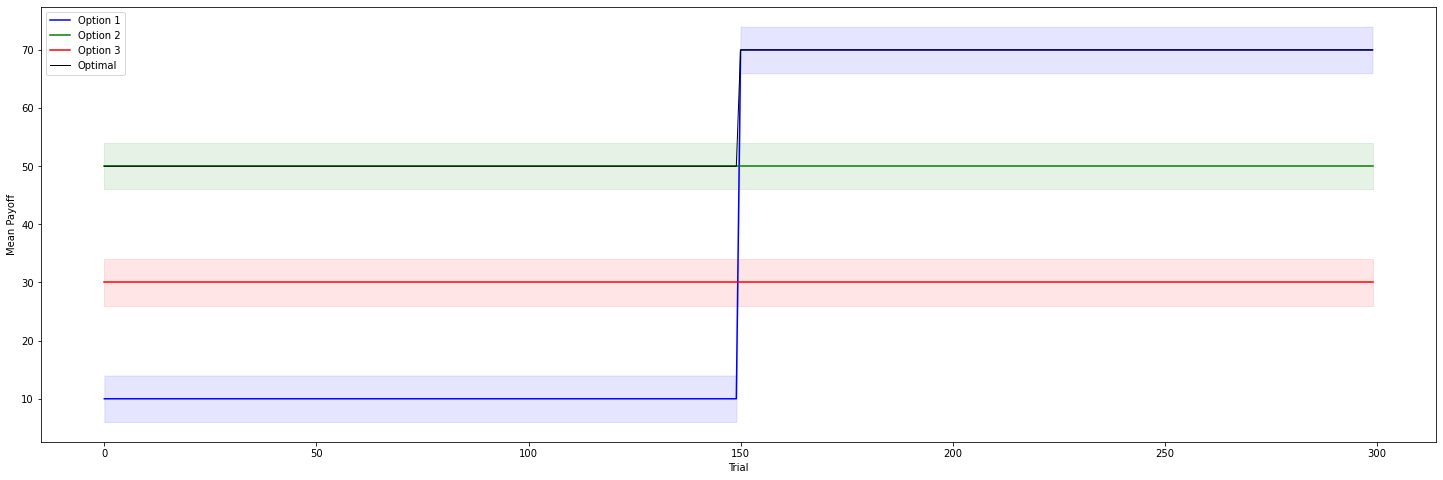

In [60]:
''' Initialising simulation class from loaded payoff function, calculating optimal solution, and printing loaded payoff function'''
total_time = 300
simu = BanditsKalman(total_time)
payoffs = np.genfromtxt('payoffs/payoffs_step2.csv',delimiter=',')
[_, optimal_scores,_] = simu.findRegret(payoffs,0)
simu.options = len(payoffs)

# Plotting payoff distribution with 1 SD error range + optimal picking overlaid
fig,ax = plt.subplots(figsize=(25,8))
colors = ['blue','green','red','orange']
for i in range(len(payoffs)):
    plt.plot(range(total_time),payoffs[i,:], color=colors[i], label='Option '+str(i+1))                
    plt.fill_between(range(total_time),payoffs[i,:]-simu.sigma, payoffs[i,:]+simu.sigma,color=colors[i],alpha=0.1)
plt.plot(range(total_time),optimal_scores,linewidth=1, color='black', label='Optimal')        # Plotting optimal score

plt.xlabel('Trial')
plt.ylabel('Mean Payoff')
plt.legend()
plt.show()

In [71]:
''' Simulating trials with the loaded payoff function for the strategies: pure exploitation, discounted softmax, discounted UCB1.
    The optimal sampling proportion from each of the options is also shown, and compared to with the proportions sampled by the softmax and UCB algorithms.'''

exploit_reward = simu.exploit(payoffs,1000)
[exploit_regret, _, optimal_choices] = simu.findRegret(payoffs,exploit_reward)
print('Pure exploit Mean Regret: %s'% np.mean(exploit_regret),', Std: %s'% np.std(exploit_regret))
unique, counts = np.unique(optimal_choices, return_counts = True)
print('Proportions sampled (optimal):   ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')

# PAYOFF 1 PARMAS: 1, 0.995
# PAYOFF 4 PARAMS: 3.55, 0.99
# STEP 1 PARAMS: 1.6, 0.99
# STEP 2 PARAMS: 3, 0.97
softmax_reward, softmax_history = simu.softmax(payoffs,4,5)
[softmax_regret, _, _] = simu.findRegret(payoffs,softmax_reward)
print('Pure Softmax Mean Regret: %s'% np.mean(softmax_regret),', Std: %s'% np.std(softmax_regret))

# print('Proportions sampled (softmax):   ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')


Pure exploit Mean Regret: 0.16997042280432118 , Std: 0.0040052404056011605
Proportions sampled (optimal):    blue: 0.5, green: 0.5

Pure Softmax Mean Regret: 0.33592073277972956 , Std: 0.0030465035588942953


In [72]:
softmax_history

array([[[  9.02363833,  40.88032746,  34.69896866],
        [  9.02363833, -23.67828595,  34.69896866],
        [  9.02363833,  40.88032746,  13.76333395],
        ...,
        [  9.02363833,  40.88032746,  34.69896866],
        [  9.02363833,  40.88032746,  34.69896866],
        [  9.02363833,  40.88032746,  34.69896866]],

       [[  3.06578839,  51.27911009,  29.13790158],
        [  3.06578839, -30.91074565,  29.13790158],
        [  3.06578839,  51.27911009,  16.99601508],
        ...,
        [  3.06578839,  51.27911009,  29.13790158],
        [  3.06578839,  51.27911009,  29.13790158],
        [  3.06578839,  51.27911009,  29.13790158]],

       [[ 14.15489781,  46.28061894,  31.7350511 ],
        [ 14.15489781, -27.43424393,  31.7350511 ],
        [ 14.15489781,  46.28061894,  15.88314223],
        ...,
        [ 14.15489781,  46.28061894,  31.7350511 ],
        [ 14.15489781,  46.28061894,  31.7350511 ],
        [ 14.15489781,  46.28061894,  31.7350511 ]],

       [[  7.097189